In [1]:
import numpy as np
import numba
from tqdm import tqdm

def generate_points(n: int, x_max: int = 100, y_max: int = 100) -> list[tuple[int, int]]:
    points = []
    while len(points) < n:
        x = np.random.randint(0, x_max)
        y = np.random.randint(0, y_max)
        if (x, y) not in points:
            points.append((x, y))
    return points

@numba.njit
def distance(p1: tuple[int, int], p2: tuple[int, int]) -> int:
    return np.abs(p1[0] - p2[0]) + np.abs(p1[1] - p2[1])

@numba.njit
def distance_noisy(p1: tuple[int, int], p2: tuple[int, int]) -> float:
    return np.abs(p1[0] - p2[0]) + np.abs(p1[1] - p2[1]) + np.random.rand() * 0.01

def compute_tour_cost(points: list[tuple[int, int]]) -> int:
    cost = 0
    for p1, p2 in zip(points, points[1:]):
        cost += distance(p1, p2)
    return cost

def nearest_neighbour_tour(points: list[tuple[int, int]], start: int = 0, noise: bool = False) -> list[tuple[int, int]]:
    unvisited = points[:]
    tour = [unvisited.pop(start)]
    while unvisited:
        last = tour[-1]
        if not noise:
            next_point = min(unvisited, key=lambda p: distance(last, p))
        else:
            next_point = min(unvisited, key=lambda p: distance_noisy(last, p))
        tour.append(next_point)
        unvisited.remove(next_point)
    return tour

def find_best_tour_1(points: list[tuple[int, int]], start: int = 0, noise: bool = False) -> list[tuple[int, int]]:
    """Compares all possible cycles then rotates the best cycle to start at `start` while also breaking the cycle."""
    best_tour = None
    best_cost = float('inf')

    for i in range(len(points)):
        tour = nearest_neighbour_tour(points, start=i, noise=noise)
        start_index = tour.index(points[start])
        tour = tour[start_index:] + tour[:start_index] # Rotate to start at `start`
        
        cost = compute_tour_cost(tour)
        if cost < best_cost:
            best_cost = cost
            best_tour = tour[:]

    return best_tour

def find_best_tour_2(points: list[tuple[int, int]], start: int = 0, noise: bool = False) -> list[tuple[int, int]]:
    """Removes start point and searches thourgh the rest of the points."""
    start_point = points[start]
    remaining_points = points[:start] + points[start+1:]
    best_tour = None
    best_cost = float('inf')

    for i in range(len(remaining_points)):
        tour = [start_point] + nearest_neighbour_tour(remaining_points, start=i, noise=noise)
        cost = compute_tour_cost(tour)
        if cost < best_cost:
            best_cost = cost
            best_tour = tour[:]
    
    return best_tour

In [5]:
n_points = 30
x_max, y_max = 10, 5
points = generate_points(n_points, x_max=x_max, y_max=y_max)
print("Points:", points, "\n")

tour = find_best_tour_1(points, start=0)
print("Best Tour:", tour)
print("Tour Cost:", compute_tour_cost(tour))

tour = find_best_tour_2(points, start=0)
print("Best Tour:", tour)
print("Tour Cost:", compute_tour_cost(tour))

Points: [(9, 4), (5, 1), (2, 0), (0, 4), (5, 3), (3, 0), (8, 2), (5, 0), (7, 1), (3, 4), (9, 0), (7, 3), (3, 1), (7, 4), (1, 3), (5, 2), (0, 1), (3, 3), (2, 3), (7, 0), (6, 0), (2, 4), (9, 3), (8, 3), (6, 4), (0, 0), (4, 3), (4, 0), (1, 1), (3, 2)] 

Best Tour: [(9, 4), (9, 3), (9, 0), (4, 0), (3, 0), (2, 0), (3, 1), (3, 2), (1, 1), (0, 1), (0, 0), (0, 4), (1, 3), (2, 3), (3, 3), (3, 4), (2, 4), (4, 3), (5, 3), (5, 2), (5, 1), (5, 0), (6, 0), (7, 0), (7, 1), (8, 2), (8, 3), (7, 3), (7, 4), (6, 4)]
Tour Cost: 45
Best Tour: [(9, 4), (7, 3), (7, 4), (6, 4), (5, 3), (5, 2), (5, 1), (5, 0), (6, 0), (7, 0), (7, 1), (8, 2), (8, 3), (9, 3), (9, 0), (4, 0), (3, 0), (2, 0), (3, 1), (3, 2), (3, 3), (3, 4), (2, 4), (2, 3), (1, 3), (0, 4), (0, 1), (0, 0), (1, 1), (4, 3)]
Tour Cost: 48


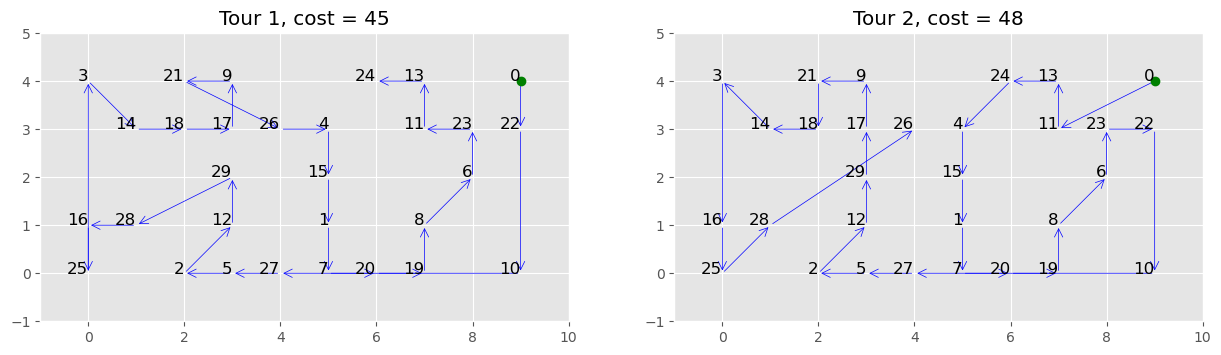

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
tour1 = find_best_tour_1(points, start=0)
tour2 = find_best_tour_2(points, start=0)

for ax in (ax1, ax2):
    ax.set_xlim(-1, x_max)
    ax.set_ylim(-1, y_max)
    ax.set_aspect('equal')

for ax, tour in zip((ax1, ax2), (tour1, tour2)):
    for p1, p2 in zip(tour, tour[1:]):
        ax.add_patch(patches.FancyArrowPatch(p1, p2, arrowstyle='->', mutation_scale=15, color='blue'))
    for i, p in enumerate(points): # Plot all points:
        # ax.plot(p[0], p[1], 'ro')
        ax.text(p[0], p[1], str(i), fontsize=12, ha='right')

    ax.plot(tour[0][0], tour[0][1], 'go')

ax1.set_title(f'Tour 1, cost = {compute_tour_cost(tour1)}')
ax2.set_title(f'Tour 2, cost = {compute_tour_cost(tour2)}')
plt.show()

## Statistics

In [7]:
import pickle

def plot_results(results):
    problem_size = results["problem_size"]
    n_trials = results["n_trials"]
    x_max = results["x_max"]
    y_max = results["y_max"]
    cost1_is_better_list = results["cost1_is_better_list"]
    cost2_is_better_list = results["cost2_is_better_list"]
    cost_are_equal_list = results["cost_are_equal_list"]
    noise_repeats = results["noise_repeats"]
    algorithm_1_name = results["algorithm_1"]
    algorithm_2_name = results["algorithm_2"]

    from matplotlib import pyplot as plt
    plt.style.use("ggplot")
    # Visualize evolution of cost comparison with problem size
    plt.plot(problem_size, cost1_is_better_list, '.-', label="Cost 1 is better")
    plt.plot(problem_size, cost2_is_better_list, '.-', label="Cost 2 is better")
    plt.plot(problem_size, cost_are_equal_list, '.-', label="Costs are equal")
    plt.xlabel("Number of Points")
    plt.ylabel("Percentage (%)")
    plt.title(f"Comparison of Two TSP Heuristics\n(n_trials={n_trials}), (map_size=({x_max},{y_max}))")
    plt.legend(title=f"Algorithms:\n1: {algorithm_1_name}\n2: {algorithm_2_name}")
    plt.show()

def plot_results_from_file(filename: str):
    with open(filename, "rb") as f:
        results = pickle.load(f)
    plot_results(results)


### Deterministic version

100%|██████████| 13/13 [01:54<00:00,  8.83s/it]


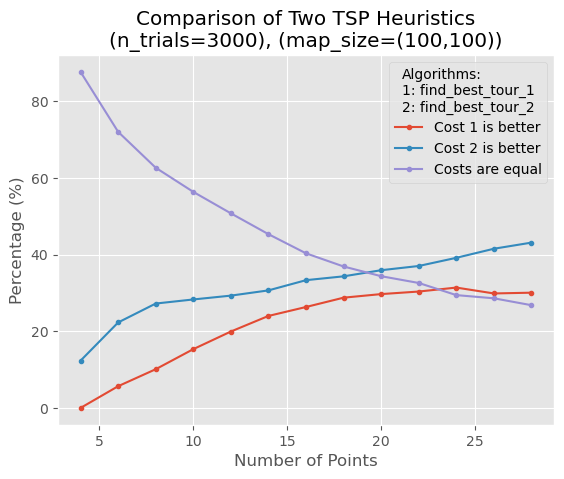

In [8]:
x_max, y_max = 100, 100
n_trials = 3_000
noise_repeats = False
problem_size = range(4, 30, 2)
algorithm_1_name = "find_best_tour_1"
algorithm_2_name = "find_best_tour_2"

cost1_is_better_list = []
cost2_is_better_list = []
cost_are_equal_list = []

for n_points in tqdm(problem_size):
    costs1 = []
    costs2 = []

    for _ in range(n_trials):
        points = generate_points(n_points, x_max=x_max, y_max=y_max)
        cost1 = compute_tour_cost(find_best_tour_1(points, start=0))
        cost2 = compute_tour_cost(find_best_tour_2(points, start=0))
        costs1.append(cost1)
        costs2.append(cost2)

    cost1_is_better = sum(c1 < c2 for c1, c2 in zip(costs1, costs2))
    cost2_is_better = sum(c2 < c1 for c1, c2 in zip(costs1, costs2))
    cost_are_equal = n_trials - cost1_is_better - cost2_is_better

    cost1_is_better_list.append(cost1_is_better / n_trials * 100)
    cost2_is_better_list.append(cost2_is_better / n_trials * 100)
    cost_are_equal_list.append(cost_are_equal / n_trials * 100)

# save results to a file
results = {
    "problem_size": list(problem_size),
    "n_trials": n_trials,
    "x_max": x_max,
    "y_max": y_max,
    "cost1_is_better_list": cost1_is_better_list,
    "cost2_is_better_list": cost2_is_better_list,
    "cost_are_equal_list": cost_are_equal_list,
    "noise_repeats": noise_repeats,
    "algorithm_1": algorithm_1_name,
    "algorithm_2": algorithm_2_name,
}

filename = f"logs/tsp_heuristics_results_trials{n_trials}_map{(x_max,y_max)}_{algorithm_1_name}_vs_{algorithm_2_name}.pkl"
with open(filename, "wb") as f:
    pickle.dump(results, f)

plot_results_from_file(filename)

100%|██████████| 13/13 [01:49<00:00,  8.44s/it]


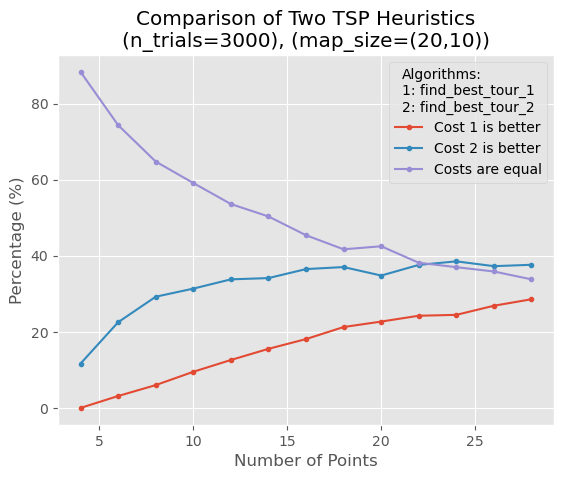

In [9]:
x_max, y_max = 20, 10
n_trials = 3_000
noise_repeats = False
problem_size = range(4, 30, 2)
algorithm_1_name = "find_best_tour_1"
algorithm_2_name = "find_best_tour_2"

cost1_is_better_list = []
cost2_is_better_list = []
cost_are_equal_list = []

for n_points in tqdm(problem_size):
    costs1 = []
    costs2 = []

    for _ in range(n_trials):
        points = generate_points(n_points, x_max=x_max, y_max=y_max)
        cost1 = compute_tour_cost(find_best_tour_1(points, start=0))
        cost2 = compute_tour_cost(find_best_tour_2(points, start=0))
        costs1.append(cost1)
        costs2.append(cost2)

    cost1_is_better = sum(c1 < c2 for c1, c2 in zip(costs1, costs2))
    cost2_is_better = sum(c2 < c1 for c1, c2 in zip(costs1, costs2))
    cost_are_equal = n_trials - cost1_is_better - cost2_is_better

    cost1_is_better_list.append(cost1_is_better / n_trials * 100)
    cost2_is_better_list.append(cost2_is_better / n_trials * 100)
    cost_are_equal_list.append(cost_are_equal / n_trials * 100)

# save results to a file
results = {
    "problem_size": list(problem_size),
    "n_trials": n_trials,
    "x_max": x_max,
    "y_max": y_max,
    "cost1_is_better_list": cost1_is_better_list,
    "cost2_is_better_list": cost2_is_better_list,
    "cost_are_equal_list": cost_are_equal_list,
    "noise_repeats": noise_repeats,
    "algorithm_1": algorithm_1_name,
    "algorithm_2": algorithm_2_name,
}

filename = f"logs/tsp_heuristics_results_trials{n_trials}_map{(x_max,y_max)}_{algorithm_1_name}_vs_{algorithm_2_name}.pkl"
with open(filename, "wb") as f:
    pickle.dump(results, f)

plot_results_from_file(filename)

100%|██████████| 13/13 [01:50<00:00,  8.49s/it]


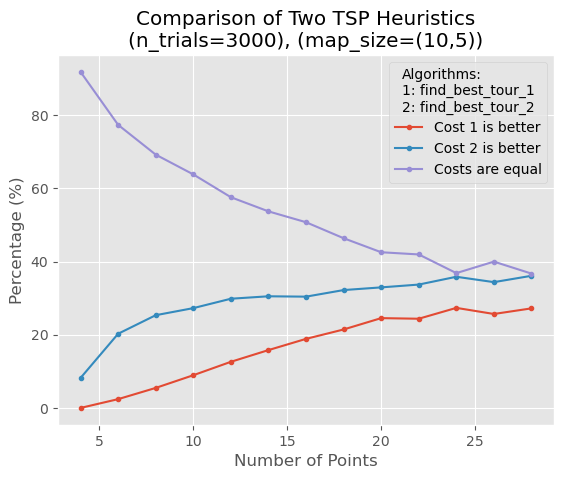

In [10]:
x_max, y_max = 10, 5
n_trials = 3_000
noise_repeats = False
problem_size = range(4, 30, 2)
algorithm_1_name = "find_best_tour_1"
algorithm_2_name = "find_best_tour_2"

cost1_is_better_list = []
cost2_is_better_list = []
cost_are_equal_list = []

for n_points in tqdm(problem_size):
    costs1 = []
    costs2 = []

    for _ in range(n_trials):
        points = generate_points(n_points, x_max=x_max, y_max=y_max)
        cost1 = compute_tour_cost(find_best_tour_1(points, start=0))
        cost2 = compute_tour_cost(find_best_tour_2(points, start=0))
        costs1.append(cost1)
        costs2.append(cost2)

    cost1_is_better = sum(c1 < c2 for c1, c2 in zip(costs1, costs2))
    cost2_is_better = sum(c2 < c1 for c1, c2 in zip(costs1, costs2))
    cost_are_equal = n_trials - cost1_is_better - cost2_is_better

    cost1_is_better_list.append(cost1_is_better / n_trials * 100)
    cost2_is_better_list.append(cost2_is_better / n_trials * 100)
    cost_are_equal_list.append(cost_are_equal / n_trials * 100)

# save results to a file
results = {
    "problem_size": list(problem_size),
    "n_trials": n_trials,
    "x_max": x_max,
    "y_max": y_max,
    "cost1_is_better_list": cost1_is_better_list,
    "cost2_is_better_list": cost2_is_better_list,
    "cost_are_equal_list": cost_are_equal_list,
    "noise_repeats": noise_repeats,
    "algorithm_1": algorithm_1_name,
    "algorithm_2": algorithm_2_name,
}

filename = f"logs/tsp_heuristics_results_trials{n_trials}_map{(x_max,y_max)}_{algorithm_1_name}_vs_{algorithm_2_name}.pkl"
with open(filename, "wb") as f:
    pickle.dump(results, f)

plot_results_from_file(filename)

### Randomized version

100%|██████████| 13/13 [29:29<00:00, 136.14s/it]


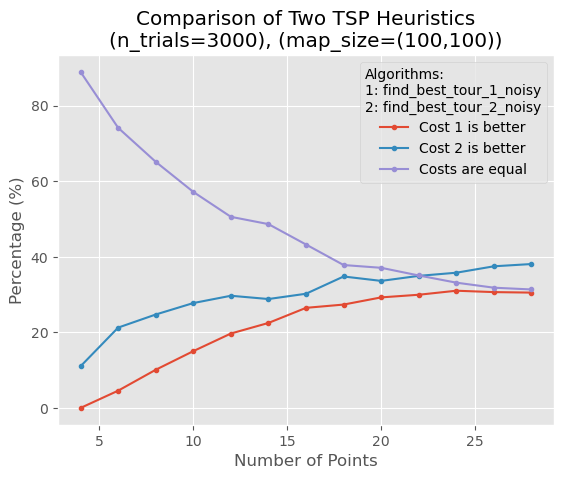

In [ ]:
x_max, y_max = 100, 100
n_trials = 3_000
noise_repeats = 15
problem_size = range(4, 30, 2)
algorithm_1_name = "find_best_tour_1_noisy"
algorithm_2_name = "find_best_tour_2_noisy"

cost1_is_better_list = []
cost2_is_better_list = []
cost_are_equal_list = []

for n_points in tqdm(problem_size):
    costs1 = []
    costs2 = []

    for _ in range(n_trials):
        points = generate_points(n_points, x_max=x_max, y_max=y_max)
        cost1 = min([compute_tour_cost(find_best_tour_1(points, start=0, noise=True)) for _ in range(noise_repeats)])
        cost2 = min([compute_tour_cost(find_best_tour_2(points, start=0, noise=True)) for _ in range(noise_repeats)])
        costs1.append(cost1)
        costs2.append(cost2)

    cost1_is_better = sum(c1 < c2 for c1, c2 in zip(costs1, costs2))
    cost2_is_better = sum(c2 < c1 for c1, c2 in zip(costs1, costs2))
    cost_are_equal = n_trials - cost1_is_better - cost2_is_better

    cost1_is_better_list.append(cost1_is_better / n_trials * 100)
    cost2_is_better_list.append(cost2_is_better / n_trials * 100)
    cost_are_equal_list.append(cost_are_equal / n_trials * 100)

# save results to a file
results = {
    "problem_size": list(problem_size),
    "n_trials": n_trials,
    "x_max": x_max,
    "y_max": y_max,
    "cost1_is_better_list": cost1_is_better_list,
    "cost2_is_better_list": cost2_is_better_list,
    "cost_are_equal_list": cost_are_equal_list,
    "noise_repeats": noise_repeats,
    "algorithm_1": algorithm_1_name,
    "algorithm_2": algorithm_2_name,
}

filename = f"logs/tsp_heuristics_results_trials{n_trials}_map{(x_max,y_max)}_{algorithm_1_name}_vs_{algorithm_2_name}.pkl"
with open(filename, "wb") as f:
    pickle.dump(results, f)

plot_results_from_file(filename)

100%|██████████| 13/13 [31:03<00:00, 143.37s/it]


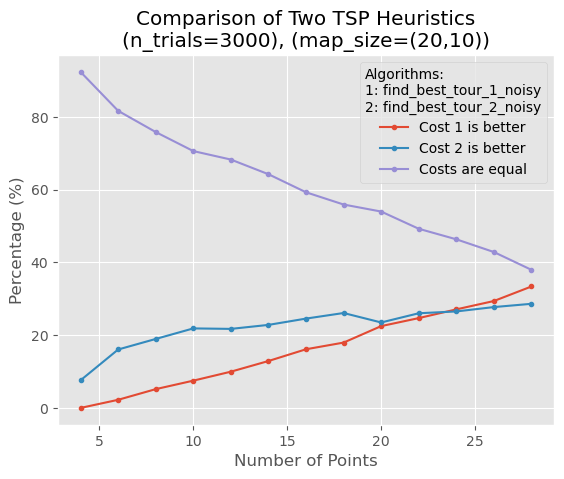

In [ ]:
x_max, y_max = 20, 10
n_trials = 3_000
noise_repeats = 15
problem_size = range(4, 30, 2)
algorithm_1_name = "find_best_tour_1_noisy"
algorithm_2_name = "find_best_tour_2_noisy"

cost1_is_better_list = []
cost2_is_better_list = []
cost_are_equal_list = []

for n_points in tqdm(problem_size):
    costs1 = []
    costs2 = []

    for _ in range(n_trials):
        points = generate_points(n_points, x_max=x_max, y_max=y_max)
        cost1 = min([compute_tour_cost(find_best_tour_1(points, start=0, noise=True)) for _ in range(noise_repeats)])
        cost2 = min([compute_tour_cost(find_best_tour_2(points, start=0, noise=True)) for _ in range(noise_repeats)])
        costs1.append(cost1)
        costs2.append(cost2)

    cost1_is_better = sum(c1 < c2 for c1, c2 in zip(costs1, costs2))
    cost2_is_better = sum(c2 < c1 for c1, c2 in zip(costs1, costs2))
    cost_are_equal = n_trials - cost1_is_better - cost2_is_better

    cost1_is_better_list.append(cost1_is_better / n_trials * 100)
    cost2_is_better_list.append(cost2_is_better / n_trials * 100)
    cost_are_equal_list.append(cost_are_equal / n_trials * 100)

# save results to a file
results = {
    "problem_size": list(problem_size),
    "n_trials": n_trials,
    "x_max": x_max,
    "y_max": y_max,
    "cost1_is_better_list": cost1_is_better_list,
    "cost2_is_better_list": cost2_is_better_list,
    "cost_are_equal_list": cost_are_equal_list,
    "noise_repeats": noise_repeats,
    "algorithm_1": algorithm_1_name,
    "algorithm_2": algorithm_2_name,
}

filename = f"logs/tsp_heuristics_results_trials{n_trials}_map{(x_max,y_max)}_{algorithm_1_name}_vs_{algorithm_2_name}.pkl"
with open(filename, "wb") as f:
    pickle.dump(results, f)

plot_results_from_file(filename)

100%|██████████| 13/13 [31:39<00:00, 146.14s/it]


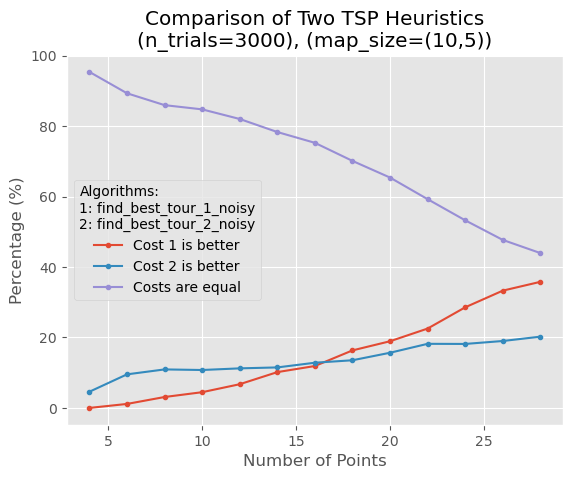

In [ ]:
x_max, y_max = 10, 5
n_trials = 3_000
noise_repeats = 15
problem_size = range(4, 30, 2)
algorithm_1_name = "find_best_tour_1_noisy"
algorithm_2_name = "find_best_tour_2_noisy"

cost1_is_better_list = []
cost2_is_better_list = []
cost_are_equal_list = []

for n_points in tqdm(problem_size):
    costs1 = []
    costs2 = []

    for _ in range(n_trials):
        points = generate_points(n_points, x_max=x_max, y_max=y_max)
        cost1 = min([compute_tour_cost(find_best_tour_1(points, start=0, noise=True)) for _ in range(noise_repeats)])
        cost2 = min([compute_tour_cost(find_best_tour_2(points, start=0, noise=True)) for _ in range(noise_repeats)])
        costs1.append(cost1)
        costs2.append(cost2)

    cost1_is_better = sum(c1 < c2 for c1, c2 in zip(costs1, costs2))
    cost2_is_better = sum(c2 < c1 for c1, c2 in zip(costs1, costs2))
    cost_are_equal = n_trials - cost1_is_better - cost2_is_better

    cost1_is_better_list.append(cost1_is_better / n_trials * 100)
    cost2_is_better_list.append(cost2_is_better / n_trials * 100)
    cost_are_equal_list.append(cost_are_equal / n_trials * 100)

# save results to a file
results = {
    "problem_size": list(problem_size),
    "n_trials": n_trials,
    "x_max": x_max,
    "y_max": y_max,
    "cost1_is_better_list": cost1_is_better_list,
    "cost2_is_better_list": cost2_is_better_list,
    "cost_are_equal_list": cost_are_equal_list,
    "noise_repeats": noise_repeats,
    "algorithm_1": algorithm_1_name,
    "algorithm_2": algorithm_2_name,
}

filename = f"logs/tsp_heuristics_results_trials{n_trials}_map{(x_max,y_max)}_{algorithm_1_name}_vs_{algorithm_2_name}.pkl"
with open(filename, "wb") as f:
    pickle.dump(results, f)

plot_results_from_file(filename)

### Closer look onto the effects of randomized search
Compare an algorithm (deterministic version) to it's randomized version

100%|██████████| 13/13 [16:40<00:00, 76.96s/it] 


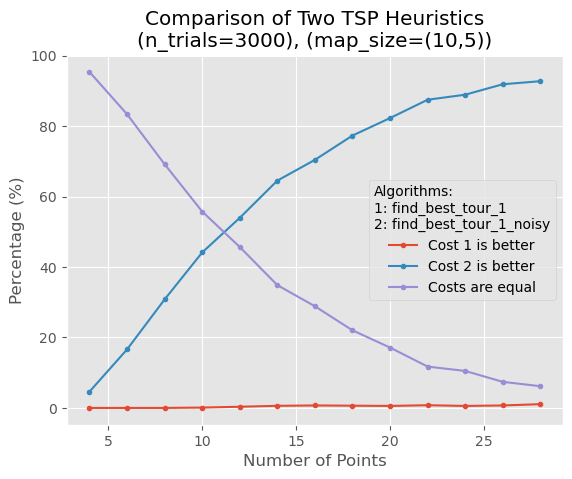

In [14]:
x_max, y_max = 10, 5
n_trials = 3_000
noise_repeats = 15
problem_size = range(4, 30, 2)
algorithm_1_name = "find_best_tour_1"
algorithm_2_name = "find_best_tour_1_noisy"

cost1_is_better_list = []
cost2_is_better_list = []
cost_are_equal_list = []

for n_points in tqdm(problem_size):
    costs1 = []
    costs2 = []

    for _ in range(n_trials):
        points = generate_points(n_points, x_max=x_max, y_max=y_max)
        cost1 = compute_tour_cost(find_best_tour_1(points, start=0, noise=False))
        cost2 = min([compute_tour_cost(find_best_tour_1(points, start=0, noise=True)) for _ in range(noise_repeats)])
        costs1.append(cost1)
        costs2.append(cost2)

    cost1_is_better = sum(c1 < c2 for c1, c2 in zip(costs1, costs2))
    cost2_is_better = sum(c2 < c1 for c1, c2 in zip(costs1, costs2))
    cost_are_equal = n_trials - cost1_is_better - cost2_is_better

    cost1_is_better_list.append(cost1_is_better / n_trials * 100)
    cost2_is_better_list.append(cost2_is_better / n_trials * 100)
    cost_are_equal_list.append(cost_are_equal / n_trials * 100)

# save results to a file
results = {
    "problem_size": list(problem_size),
    "n_trials": n_trials,
    "x_max": x_max,
    "y_max": y_max,
    "cost1_is_better_list": cost1_is_better_list,
    "cost2_is_better_list": cost2_is_better_list,
    "cost_are_equal_list": cost_are_equal_list,
    "noise_repeats": noise_repeats,
    "algorithm_1": algorithm_1_name,
    "algorithm_2": algorithm_2_name,
}

filename = f"logs/tsp_heuristics_results_trials{n_trials}_map{(x_max,y_max)}_{algorithm_1_name}_vs_{algorithm_2_name}.pkl"
with open(filename, "wb") as f:
    pickle.dump(results, f)

plot_results_from_file(filename)

100%|██████████| 13/13 [14:48<00:00, 68.35s/it] 


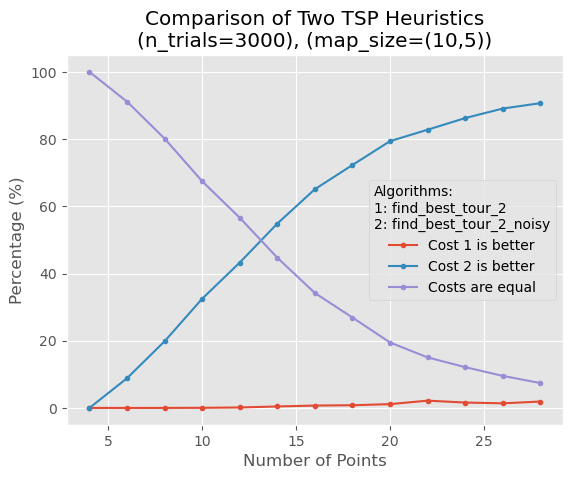

In [15]:
x_max, y_max = 10, 5
n_trials = 3_000
noise_repeats = 15
problem_size = range(4, 30, 2)
algorithm_1_name = "find_best_tour_2"
algorithm_2_name = "find_best_tour_2_noisy"

cost1_is_better_list = []
cost2_is_better_list = []
cost_are_equal_list = []

for n_points in tqdm(problem_size):
    costs1 = []
    costs2 = []

    for _ in range(n_trials):
        points = generate_points(n_points, x_max=x_max, y_max=y_max)
        cost1 = compute_tour_cost(find_best_tour_2(points, start=0, noise=False))
        cost2 = min([compute_tour_cost(find_best_tour_2(points, start=0, noise=True)) for _ in range(noise_repeats)])
        costs1.append(cost1)
        costs2.append(cost2)

    cost1_is_better = sum(c1 < c2 for c1, c2 in zip(costs1, costs2))
    cost2_is_better = sum(c2 < c1 for c1, c2 in zip(costs1, costs2))
    cost_are_equal = n_trials - cost1_is_better - cost2_is_better

    cost1_is_better_list.append(cost1_is_better / n_trials * 100)
    cost2_is_better_list.append(cost2_is_better / n_trials * 100)
    cost_are_equal_list.append(cost_are_equal / n_trials * 100)

# save results to a file
results = {
    "problem_size": list(problem_size),
    "n_trials": n_trials,
    "x_max": x_max,
    "y_max": y_max,
    "cost1_is_better_list": cost1_is_better_list,
    "cost2_is_better_list": cost2_is_better_list,
    "cost_are_equal_list": cost_are_equal_list,
    "noise_repeats": noise_repeats,
    "algorithm_1": algorithm_1_name,
    "algorithm_2": algorithm_2_name,
}

filename = f"logs/tsp_heuristics_results_trials{n_trials}_map{(x_max,y_max)}_{algorithm_1_name}_vs_{algorithm_2_name}.pkl"
with open(filename, "wb") as f:
    pickle.dump(results, f)

plot_results_from_file(filename)

In [151]:
np.mean(costs1), np.mean(costs2)

(79.9505, 79.604)